In [70]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score
from sklearn.decomposition import KernelPCA, PCA
import warnings
warnings.filterwarnings("ignore")

In [71]:
X_train = pd.read_csv('data/umist_cropped.csv')

In [72]:
print(X_train.shape)

(600, 10304)


In [73]:
from sklearn.preprocessing import MinMaxScaler
trans = MinMaxScaler()
X_train = trans.fit_transform(X_train)

In [74]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,perplexity=10, random_state=42)
X_train_tsne = tsne.fit_transform(X_train)

In [75]:
from sklearn.mixture import GaussianMixture
# Calculate BIC.
max_cluster = 25

cluster_range = range(1,max_cluster)

def compute_bic(X):
    all_bic_values = []
    covariance_types = ['full', 'tied', 'diag', 'spherical']
    for ctype in covariance_types:
        bic_values=[]
        for i in cluster_range:
            gmm = GaussianMixture(n_components=i, covariance_type=ctype, random_state=42)
            gmm.fit(X)
            bic_values.append(gmm.bic(X))
        all_bic_values.append(bic_values)
    return all_bic_values

bic = compute_bic(X_train_tsne)

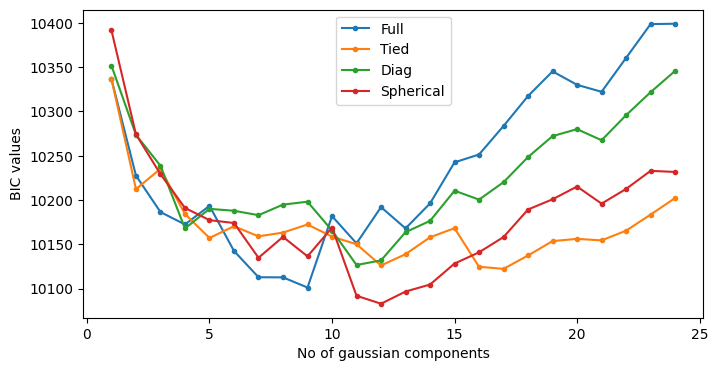

In [76]:
plt.figure(figsize=(8,4))
plt.plot(cluster_range, bic[0], marker = '.', label ='Full')
plt.plot(cluster_range, bic[1], marker = '.', label ='Tied')
plt.plot(cluster_range, bic[2], marker = '.', label ='Diag')
plt.plot(cluster_range, bic[3], marker = '.', label ='Spherical')
plt.xlabel("No of gaussian components")
plt.ylabel("BIC values")
plt.legend()
plt.show()

In [77]:
print(f'The minimum BIC by Full : {np.min(bic[0])}')
print(f'The minimum BIC by Tied : {np.min(bic[1])}')
print(f'The minimum BIC by Diag : {np.min(bic[2])}')
print(f'The minimum BIC by Spherical : {np.min(bic[3])}')

The minimum BIC by Full : 10101.312174650784
The minimum BIC by Tied : 10122.384865049908
The minimum BIC by Diag : 10126.738284731855
The minimum BIC by Spherical : 10083.033941794494


In [78]:
con_type_index = np.argmin([np.min(bic[0]),np.min(bic[1]),np.min(bic[2]),np.min(bic[3])])
con_type = "full"
if con_type_index == 0:
    con_type = "full"
elif con_type_index == 1:
    con_type = "tied"
elif con_type_index == 2:
    con_type = "diag"
else:
    con_type = "spherical"

In [79]:
k = np.argmin(bic[con_type_index])+1
print(f'The best covariance type: {con_type}')
print(f'The optimal number of clusters: {k}')

The best covariance type: spherical
The optimal number of clusters: 12


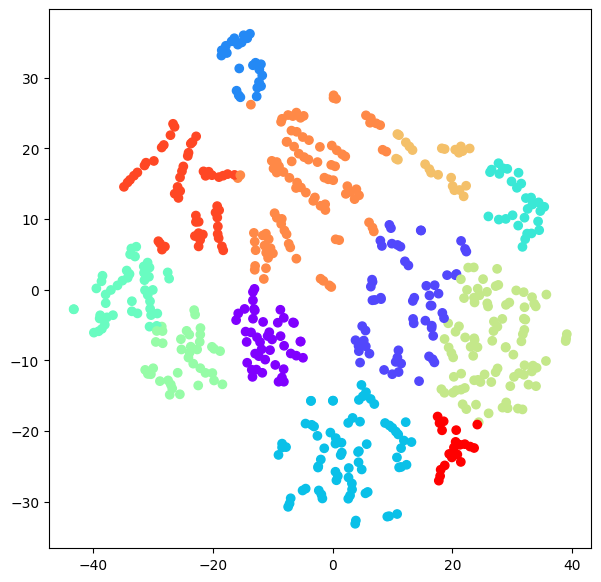

In [80]:
gmm = GaussianMixture(n_components=k, covariance_type=con_type, random_state=42)
gmm.fit(X_train_tsne)

labels_hard = gmm.predict(X_train_tsne)
plt.figure(figsize=(7,7))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=labels_hard, cmap='rainbow')
plt.show()

In [81]:
print(f'Silhouette Score: {silhouette_score(X_train_tsne, labels_hard)}')

Silhouette Score: 0.37967318296432495


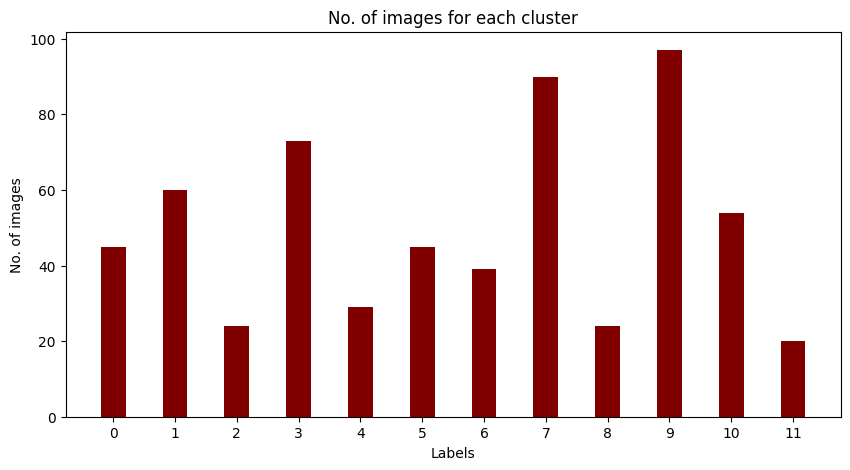

In [82]:
from collections import Counter
def plot_labels(dataset):
    data = Counter(dataset)
    courses = list(data.keys())
    values = list(data.values())
     
    fig = plt.figure(figsize = (10, 5))
    
    # creating the bar plot
    plt.bar(courses, values, color ='maroon', 
            width = 0.4)
    
    plt.xlabel("Labels")
    plt.ylabel("No. of images")
    plt.title("No. of images for each cluster")
    plt.xticks(range(k))
    plt.show()
plot_labels(labels_hard)

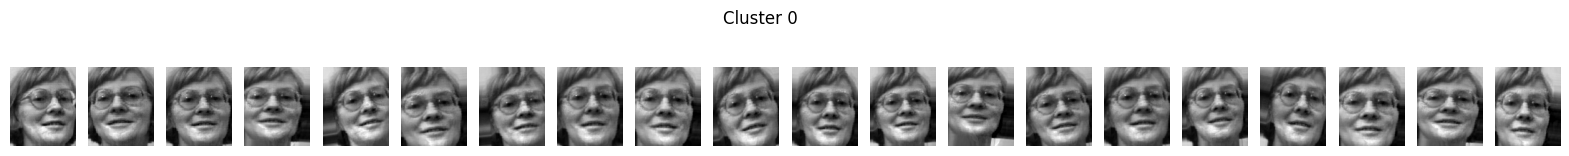

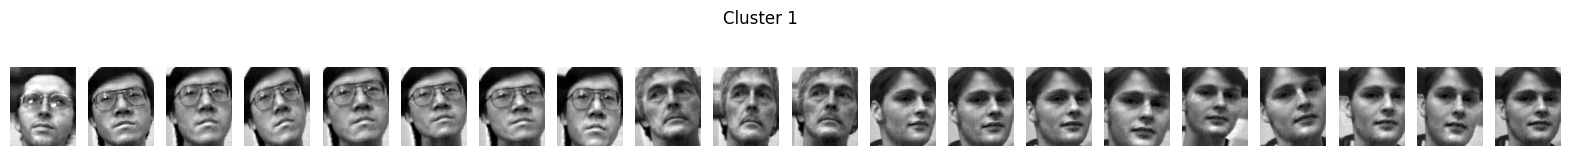

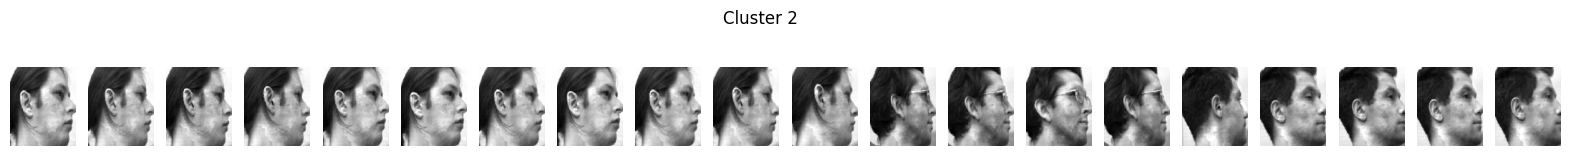

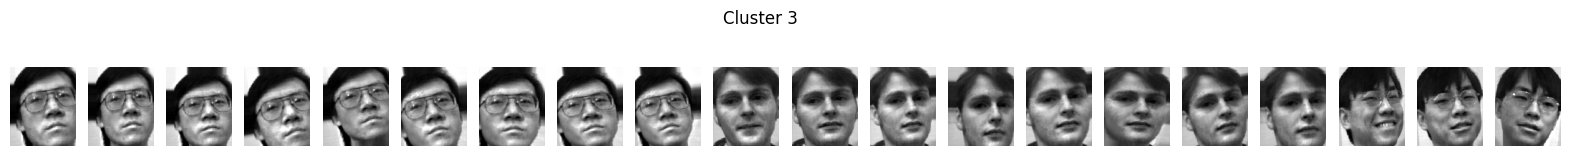

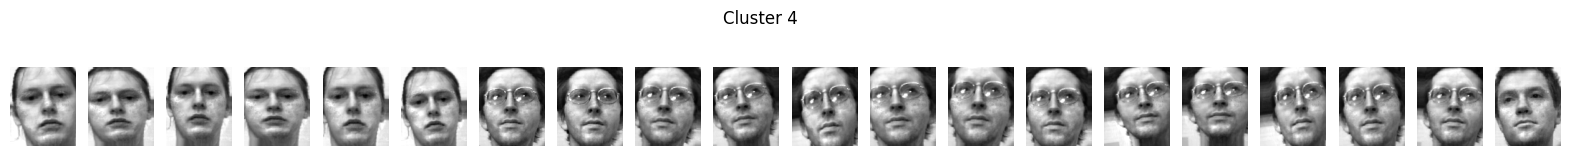

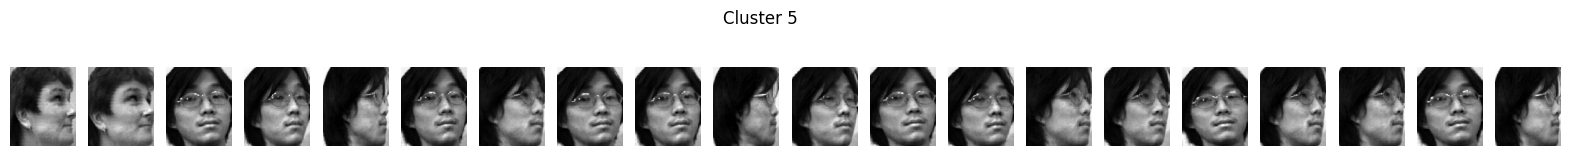

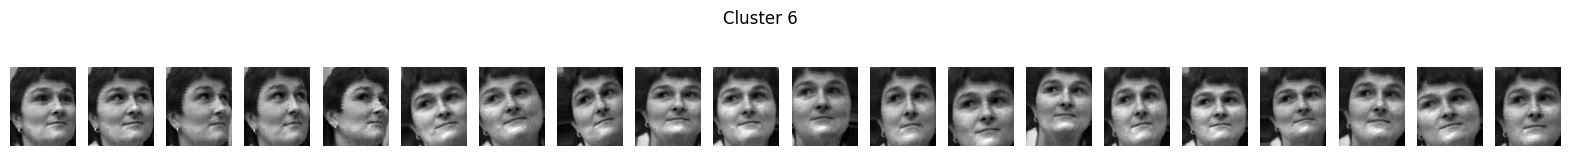

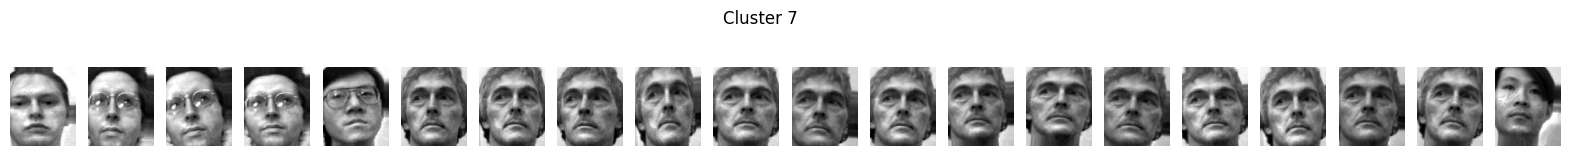

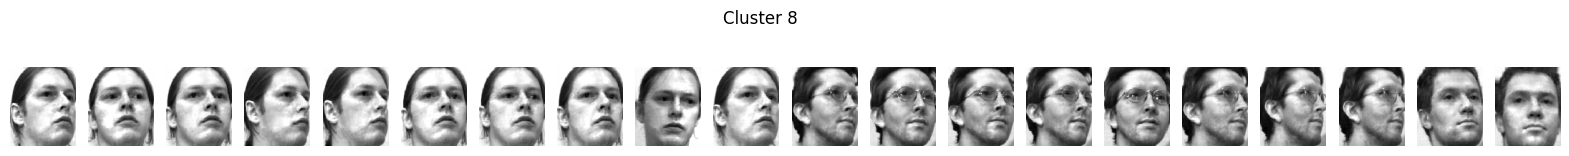

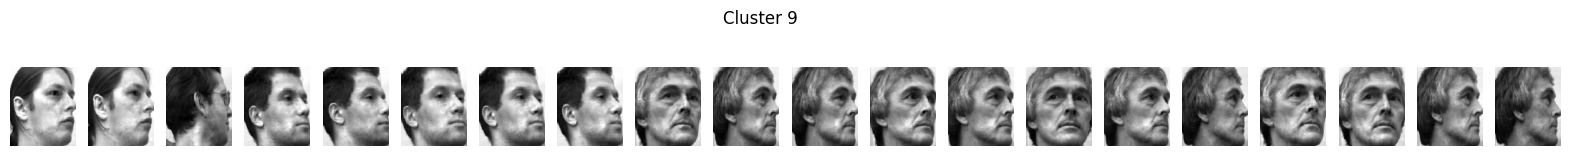

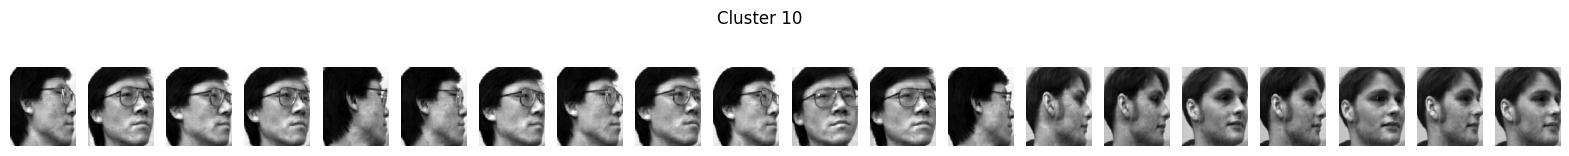

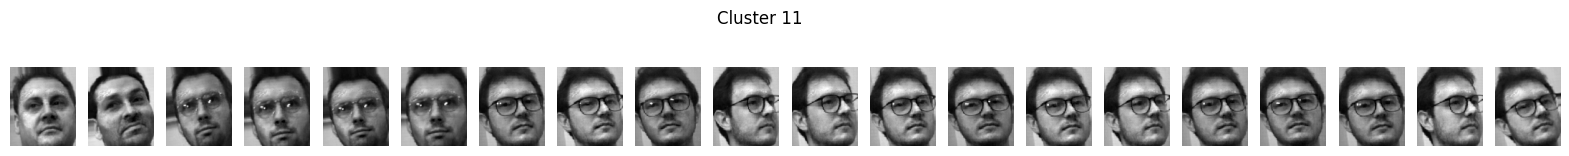

In [83]:
# Plot the first 10 images in each cluster
for cluster_id in range(21):
    # Get the indices of images in the current cluster
    cluster_indices = np.where(labels_hard == cluster_id)[0]
    
    # Determine the number of images to plot
    num_images = min(20, len(cluster_indices))
    
    if num_images > 0:
        fig, axes = plt.subplots(1, num_images, figsize=(20, 2))
        
        for i in range(num_images):
            # Get the image index
            image_index = cluster_indices[i]
            
            # Get the image data
            image_data = X_train[image_index]
            
            # Reshape the image data
            image_data = image_data.reshape(112, 92)
            
            # Plot the image
            if num_images == 1:
                axes.imshow(image_data, cmap='gray')
                axes.axis('off')
            else:
                axes[i].imshow(image_data, cmap='gray')
                axes[i].axis('off')
            
        plt.suptitle(f"Cluster {cluster_id}")
        plt.show()

In [84]:
# Plot the distribution of each cluster
original_data = pd.read_csv("data/umist_with_original_face_id.csv")

In [85]:
original_data['cluster_id'] = labels_hard

In [86]:
original_labels = original_data['label']
clustered_labels = original_data['cluster_id']

In [87]:
unique_labels = np.unique(original_labels)
unique_clustered_labels = np.unique(clustered_labels)

original_labels = original_labels.to_numpy()
clustered_labels = clustered_labels.to_numpy()

In [88]:
def autopct_format(pct):
    return f'{pct:.1f}%' if pct >= 10 else ''

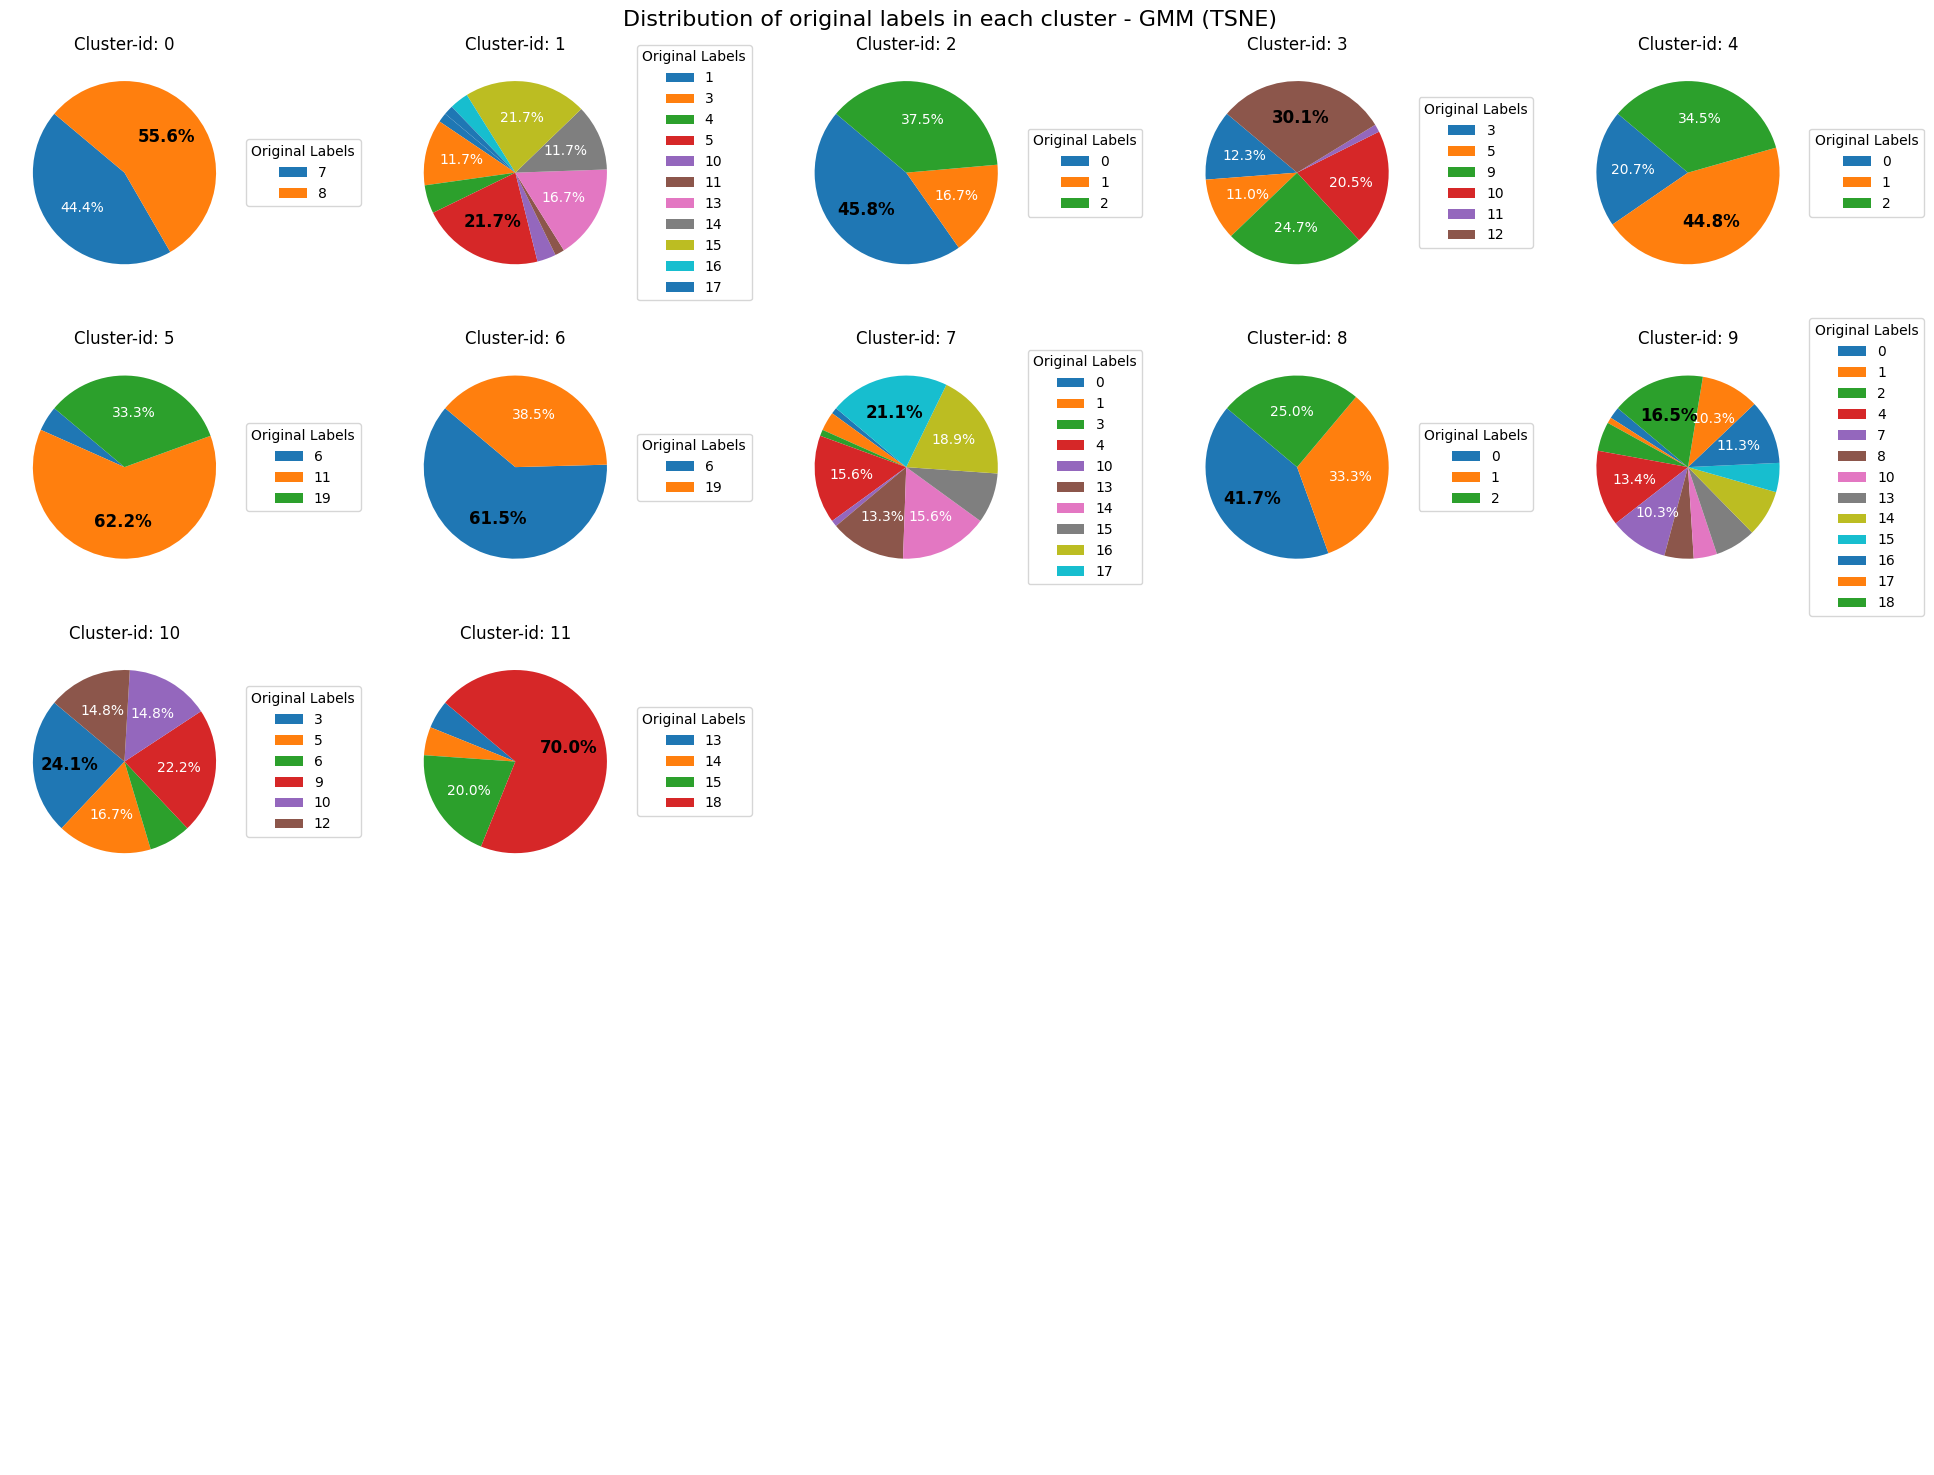

In [89]:
df = pd.DataFrame({'Original Labels': original_labels, 'Clustered Labels': clustered_labels})

num_clusters = len(unique_clustered_labels)
fig, axes = plt.subplots(5, 5, figsize=(20, 15), subplot_kw=dict(aspect="equal"))

axes = axes.flatten()

for i, cluster in enumerate(unique_clustered_labels):
    cluster_data = df[df['Clustered Labels'] == cluster]
    cluster_original_labels = cluster_data['Original Labels']
    
    cluster_original_labels_count = Counter(cluster_original_labels)
    labels = list(cluster_original_labels_count.keys())
    counts = list(cluster_original_labels_count.values())
    
    wedges, texts, autotexts = axes[i].pie(counts, labels=labels, autopct=lambda pct: autopct_format(pct), textprops=dict(color="w"), startangle=140)
    
    axes[i].legend(wedges, labels, title='Original Labels', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    
    largest_pct_idx = np.argmax(counts)
    autotexts[largest_pct_idx].set_color('black')
    autotexts[largest_pct_idx].set_fontsize(12)
    autotexts[largest_pct_idx].set_fontweight('bold')
        
    axes[i].set_title(f'Cluster-id: {cluster}')
        
    
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
        
plt.suptitle('Distribution of original labels in each cluster - GMM (TSNE)', fontsize=16)
plt.tight_layout()
plt.show()